In [55]:
pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto

import pm4py

In [57]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [139]:
import gzip
dom_decl_filename = '/content/gdrive/My Drive/_ComputerScience/BusinessInformationSystems/BPI_challenge_2020/DomesticDeclarations/DomesticDeclarations.xes.gz'
dom_decl_log = xes_importer.apply(dom_decl_filename)

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [152]:
print(dom_decl_log[0])
print(dom_decl_log[0][0])

{'attributes': {'id': 'declaration 86791', 'concept:name': 'declaration 86791', 'BudgetNumber': 'budget 86566', 'DeclarationNumber': 'declaration number 86792', 'Amount': 26.85120450862128}, 'events': [{'id': 'st_step 86794_0', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Declaration SUBMITTED by EMPLOYEE', 'time:timestamp': datetime.datetime(2017, 1, 9, 9, 49, 50, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'EMPLOYEE', 'case:id': 'declaration 86791', 'case:concept:name': 'declaration 86791', 'case:BudgetNumber': 'budget 86566', 'case:DeclarationNumber': 'declaration number 86792', 'case:Amount': 26.85120450862128}, '..', {'id': 'dd_declaration 86791_20', 'org:resource': 'SYSTEM', 'concept:name': 'Payment Handled', 'time:timestamp': datetime.datetime(2017, 1, 12, 17, 31, 22, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'UNDEFINED', 'case:id': 'declaration 86791', 'case:concept:name': 'declaration 86791', 'case:BudgetNumber': 

In [153]:
len(dom_decl_log)

10365

In [154]:
dom_decl_log = pm4py.filter_start_activities(dom_decl_log, {'Declaration SUBMITTED by EMPLOYEE'})
len(dom_decl_log)

10365

In [155]:
dom_decl_log = pm4py.filter_end_activities(dom_decl_log, 'Payment Handled')
len(dom_decl_log)

10042

In [156]:
dom_dec_log = log_converter.apply(dom_decl_log, variant=log_converter.Variants.TO_DATA_FRAME)

profile = dom_dec_log.groupby('case:concept:name').agg(
Activity = ('concept:name', 'count'),\
Activity_list = ('concept:name', lambda x: ','.join(x) ),\
Resource = ('org:resource', 'nunique'),\
Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
)

In [157]:
# filtering and basic analysis
wrong_duration = profile[(profile['Duration'] < '0:10:0')]
print('wrong duration', wrong_duration)

short_activity_list = profile[(profile['Activity']) == 1]
print('short act list:', short_activity_list)

# question 1
mean_duration = profile[(profile['Duration'] > '0:0:0')].agg('mean')
print('mean dur = ', mean_duration)

wrong duration Empty DataFrame
Columns: [Activity, Activity_list, Resource, Duration]
Index: []
short act list: Empty DataFrame
Columns: [Activity, Activity_list, Resource, Duration]
Index: []
mean dur =  Activity                      5.489643
Resource                           2.0
Duration    11 days 14:49:25.260007966
dtype: object


/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:577: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(*args, **kwargs)


In [158]:
def filter_declaration(decl_df):
  decl_df = decl_df[decl_df['Activity'] > 2]
  decl_df = decl_df[decl_df['Duration'] > '25:0:0']
  return decl_df

In [159]:
dom_decl_df = filter_declaration(profile)
print(dom_decl_df)

                    Activity  \
case:concept:name              
declaration 100000         5   
declaration 100005         5   
declaration 100010         5   
declaration 100015         6   
declaration 100021         6   
...                      ...   
declaration 99973          5   
declaration 99978          5   
declaration 99983          6   
declaration 99989          6   
declaration 99995          5   

                                                        Activity_list  \
case:concept:name                                                       
declaration 100000  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100005  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100010  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100015  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100021  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
...                                                               ...   

In [160]:
from pm4py.algo.filtering.log.variants import variants_filter
variant_dom_decl = variants_filter.get_variants(dom_decl_log)

In [161]:
from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(dom_decl_log)

In [163]:
len(variants_count)

63

In [162]:
variants_count

[{'count': 4618,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 2473,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 1392,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 575,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by PRE_APPROVER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 345,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration REJECTED by ADMINISTRATION,Declaration REJECTED by EMPLOYEE,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},


In [171]:
def analyse_variant(variants_count):
  count_sum = 0
  for variant in variants_count:
    count_sum += variant['count']
  print("sum = ", count_sum)

  handled_count = 0
  never_approved = 0
  rejected = 0
  resubmitted = 0
  double_payments = 0
  approved_by_supervisor_count = 0
  for variant in variants_count:
    #print(variant['variant'])
    if "Handled" in variant['variant']:
      handled_count += variant['count']
    if "APPROVED" not in variant['variant']:
      never_approved += variant['count']
    if "REJECTED" in variant['variant']:
      rejected += variant['count']
    # resubmit
    if variant['variant'].count('SUBMITTED') > 1:
      resubmitted += variant['count'] * (variant['variant'].count('SUBMITTED') - 1)
    if variant['variant'].count('Payment Handled') > 1:
      double_payments += variant['count']
    if 'Declaration FINAL_APPROVED by SUPERVISOR' in variant['variant']:
      approved_by_supervisor_count += variant['count']

  print('handled_count', handled_count)
  handled_ratio = handled_count / count_sum
  print("handled ratio = ", handled_ratio)
  print("never approved = ", never_approved)
  print("never approved ratio = ", never_approved / count_sum)
  print("REJECTED = ", rejected)
  print("resubmitted", resubmitted)
  print("double payment", double_payments)
  print("final approved by supervisor", approved_by_supervisor_count)

In [172]:
analyse_variant(variants_count)

sum =  10042
handled_count 10042
handled ratio =  1.0
never approved =  0
never approved ratio =  0.0
REJECTED =  978
resubmitted 1119
double payment 0
final approved by supervisor 10042


In [178]:
variant_distr = []
for variant in variants_count:
  variant_distr.append(variant['count'])

In [187]:
for variant in variant_distr:
  if variant < 10:
    variant_distr.remove(variant)

[4618, 2473, 1392, 575, 345, 188, 77, 57, 49, 40, 36, 29, 22, 20, 14, 10, 7, 6, 4, 3, 2, 1, 1, 1, 1]


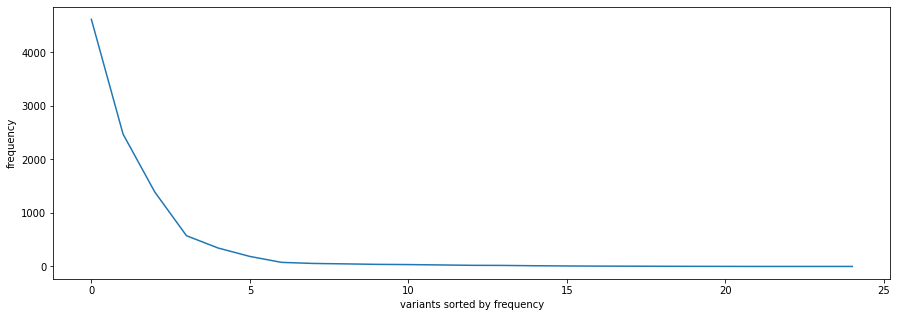

In [188]:
fig = plt.figure(figsize = (15, 5))
print(variant_distr)

#plt.hist(profile['Duration'].values, color = 'orange')
plt.plot(variant_distr)
plt.xlabel('variants sorted by frequency')
plt.ylabel('frequency')
plt.show()

In [194]:
import statistics

mean = statistics.mean(variant_distr)
median = statistics.median(variant_distr)
mode = statistics.mode(variant_distr)

print('mean =', mean)
print('median =', median)
print('mode = ', mode)

mean = 398.84
median = 22
mode =  1


In [74]:
# with int decl we can't filter data on start activity, because start-end dates of trip can be submitted in advance before submitting declaration
# there is no need to pay apriori

In [166]:
int_decl_filename = '/content/gdrive/My Drive/_ComputerScience/BusinessInformationSystems/BPI_challenge_2020/InternationalDeclarations/InternationalDeclarations.xes.gz'
int_decl_log = xes_importer.apply(int_decl_filename)

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [167]:
int_decl_log = log_converter.apply(int_decl_log, variant=log_converter.Variants.TO_DATA_FRAME)

profile = int_decl_log.groupby('case:concept:name').agg(
Activity = ('concept:name', 'count'),\
Activity_list = ('concept:name', lambda x: ','.join(x) ),\
Resource = ('org:resource', 'nunique'),\
Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
)

In [168]:
int_decl_df = filter_declaration(profile)
print(int_decl_df)

                   Activity  \
case:concept:name             
declaration 1002         10   
declaration 10024        12   
declaration 10026        12   
declaration 10046        10   
declaration 10069        10   
...                     ...   
declaration 9934         10   
declaration 9945         10   
declaration 9955         12   
declaration 9968         18   
declaration 9995         18   

                                                       Activity_list  \
case:concept:name                                                      
declaration 1002   Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10024  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10026  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10046  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10069  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
...                                                              ...   
declaration 9934   P

In [169]:
variant_int_decl = variants_filter.get_variants(int_decl_log)
variants_count_int = case_statistics.get_variant_statistics(int_decl_log)

In [170]:
analyse_variant(variants_count_int)

sum =  6449
handled_count 6187
handled ratio =  0.9593735462862459
never approved =  20
never approved ratio =  0.0031012560086835167
REJECTED =  1755
resubmitted 7915
double payment 0


[1152673000000000  201143000000000  200876000000000  534259000000000
 1059925000000000  979824000000000  626223000000000  616499000000000
 1136153000000000  530737000000000]


TypeError: ignored

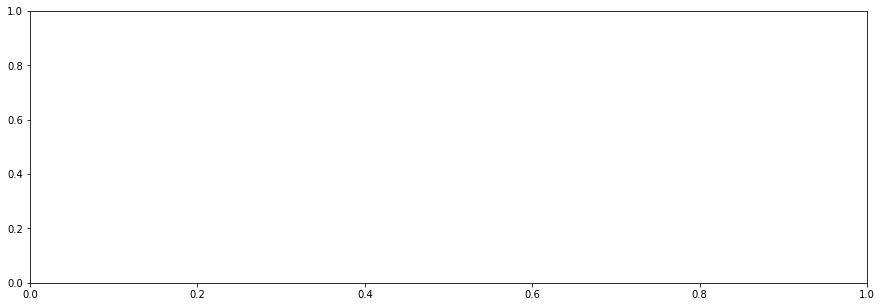

In [ ]:
fig = plt.figure(figsize = (15, 5))
print(profile['Duration'].values[0:10])

plt.hist(profile['Duration'].values, color = 'orange')
#plt.xlabel('variants sorted by frequency')
#plt.ylabel('frequency')
plt.show()

In [ ]:
len(dom_decl_log)

10500

In [ ]:
from pm4py.objects.petri_net.importer import importer as pnml_importer

In [ ]:
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(dom_decl_log)

/usr/local/lib/python3.7/dist-packages/pm4py/visualization/petrinet/__init__.py:20: UserWarning: please use the pm4py.visualization.petri_net package instead
  warnings.warn("please use the pm4py.visualization.petri_net package instead")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  after removing the cwd from sys.path.


replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

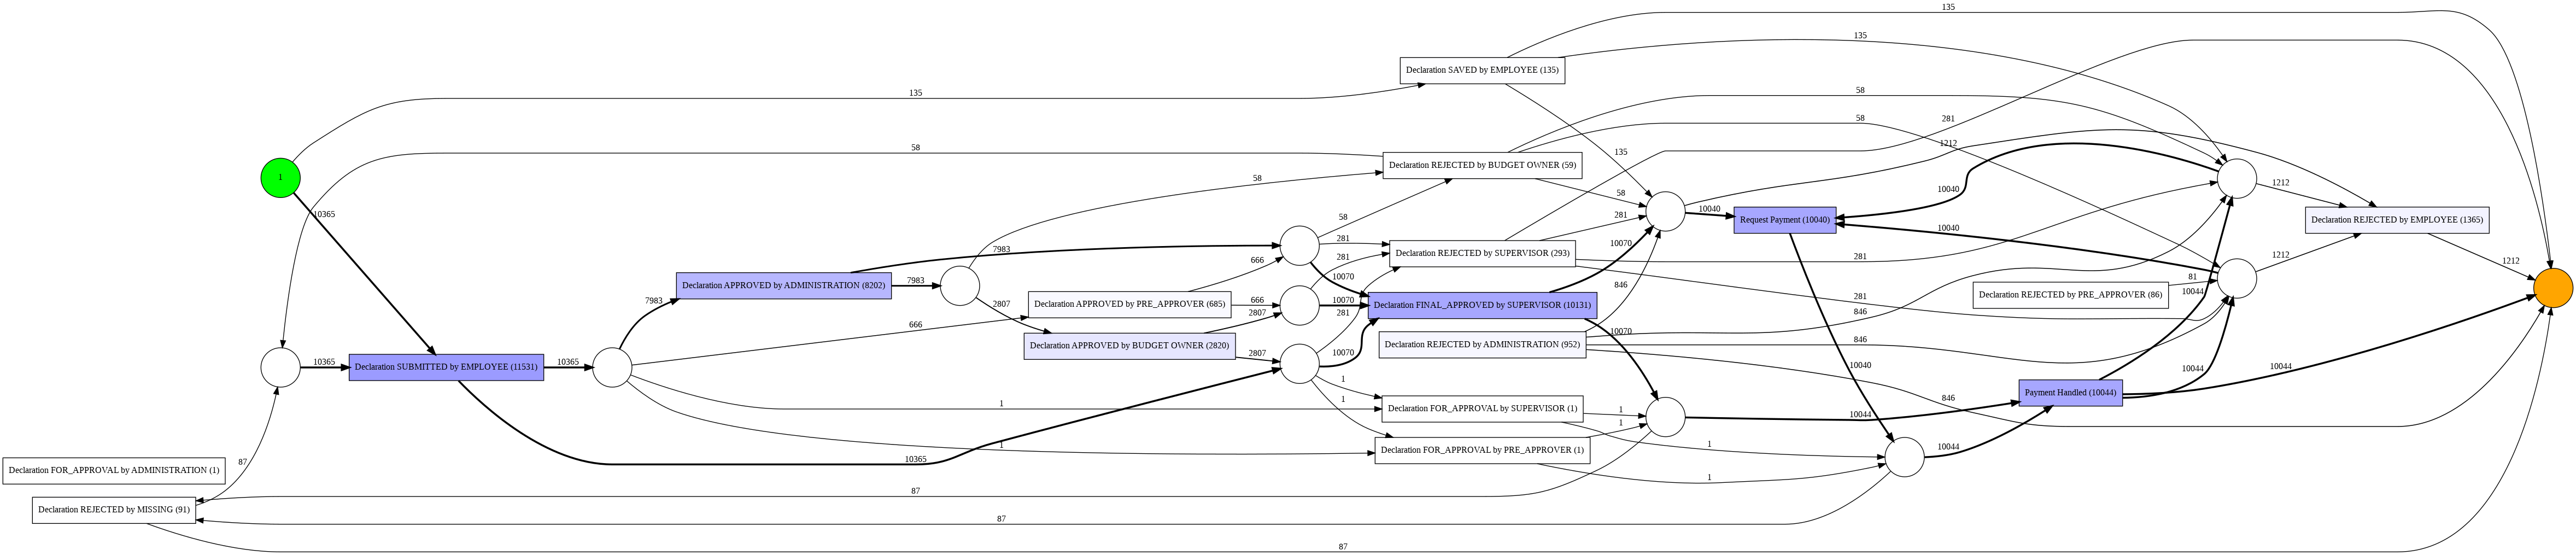

In [ ]:
## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=dom_decl_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness_alpha = replay_fitness_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('fitness alpha miner:', round(fitness_alpha['average_trace_fitness'], 2))

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

fitness alpha miner: 0.7


In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec_alpha = precision_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('precision alpha miner:', round(prec_alpha, 2))

replaying log with TBR, completed variants ::   0%|          | 0/324 [00:00<?, ?it/s]

precision alpha miner: 0.25
